### Библиотеки

In [1]:
! pip install -q kaggle torchmetrics datasets evaluate
! pip install --upgrade -q torch transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import os
import shutil
from sklearn import preprocessing
import string
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModel, AdamW, get_scheduler, Trainer, TrainingArguments
from transformers import pipeline
from transformers import RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification, RobertaModel
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import AutoTokenizer, DistilBertForSequenceClassification

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import time
from evaluate import load
import nltk
nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from datasets import  load_metric
from datasets import load_dataset, load_metric
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import classification_report


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Загружаем данные

In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.mkdir('/content/project')
os.chdir('/content/project')
shutil.copyfile('/content/drive/MyDrive/kagle-json/kaggle.json',
               '/content/project/kaggle.json')

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
! kaggle datasets download inigolopezrioboo/a-tripadvisor-dataset-for-nlp-tasks
! unzip a-tripadvisor-dataset-for-nlp-tasks -x Barcelona_reviews.csv London_reviews.csv New_Delhi_reviews.csv New_York_reviews.csv Paris_reviews.csv
#  разархивирую только нужный мне файл
df = pd.read_csv('/content/project/Madrid_reviews.csv')
df.head()

 96% 569M/591M [00:09<00:00, 89.3MB/s]
100% 591M/591M [00:09<00:00, 67.7MB/s]
Archive:  a-tripadvisor-dataset-for-nlp-tasks.zip
  inflating: Madrid_reviews.csv      


,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
0,0,1,Sushi_Yakuza,4,Positive,review_731778139,Good sushi option,"The menu of Yakuza is a bit of a lottery, some...","The menu of Yakuza is a bit of a lottery, some...","December 10, 2019",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
1,10,11,Azotea_Forus_Barcelo,1,Negative,review_766657436,Light up your table at night,Check your bill when you cancel just in case y...,Check your bill when you cancel just in case y...,"August 23, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
2,11,12,Level_Veggie_Bistro,5,Positive,review_749493592,Delicious,I had the yuca profiteroles and the veggie bur...,I had the yuca profiteroles and the veggie bur...,"March 6, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
3,12,13,Sto_Globo_Sushi_Room,5,Positive,review_772422246,Loved this place,A friend recommended this place as one of the ...,A friend recommended this place as one of the ...,"September 29, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_3
4,13,14,Azotea_Forus_Barcelo,5,Positive,review_761855600,Amazing terrace in madrid,Amazing terrace in madrid - great atmosphere a...,Amazing terrace in madrid - great atmosphere a...,"July 27, 2020",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_4


### Обработка

In [5]:
df = df[['review_full', 'sample']]
# возьму от датасета нужные мне колонки
df.head()

,review_full,sample
0,"The menu of Yakuza is a bit of a lottery, some...",Positive
1,Check your bill when you cancel just in case y...,Negative
2,I had the yuca profiteroles and the veggie bur...,Positive
3,A friend recommended this place as one of the ...,Positive
4,Amazing terrace in madrid - great atmosphere a...,Positive


In [6]:
print(len(df['review_full'][df['review_full'].duplicated()]))
# количество дубликатов

65


In [7]:
df.drop_duplicates('review_full', keep='first',inplace=True)
df.shape
# удалю дубликаты и посмотрю размер датасета

(176783, 2)

In [8]:
df['sample'].value_counts()
# данные не сбалансированы

Positive    144799
Negative     31984
Name: sample, dtype: int64

In [9]:
df['sample'] = df['sample'].map({'Positive' : 1, 'Negative': 0})
# приведу колонку sample к виду (0,1)

In [10]:
def preprocess(doc):
    """
    Функция принимает в себя документ
    меняет все буквы на нижний регистр
    и удаляет знаки припинания и символы
    """
    doc = doc.lower()
    for p in string.punctuation + string.whitespace :
        doc = doc.replace(p, ' ')
    for p in ['«', '»', '\'', '\"']:
        doc = doc.replace(p, ' ')
    doc = doc.strip()
    doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

df['review_full'] = df['review_full'].map(preprocess)
df.head()

,review_full,sample
0,the menu of yakuza is a bit of a lottery some ...,1
1,check your bill when you cancel just in case y...,0
2,i had the yuca profiteroles and the veggie bur...,1
3,a friend recommended this place as one of the ...,1
4,amazing terrace in madrid great atmosphere and...,1


max_length: 175


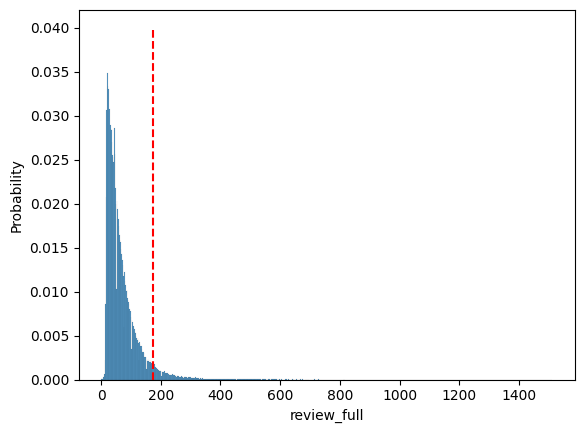

In [11]:
sentence_length = df['review_full'].apply(lambda x: len(x.split()))
ax = sns.histplot(sentence_length, stat='probability')
max_length = int(sentence_length.quantile(0.95))
ax.vlines(max_length, 0, 0.04, color='red', ls='--');
print('max_length:', max_length)
# посмотрю квантиль 0.95 длины предложения и отрисую на графике

In [12]:
# обрезаю все длинные документы по 0,95 квантилю
df['review_full'] = df['review_full'].apply(lambda x: ' '.join(x.split()[:175]) if len(x.split())>175 else x)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176783 entries, 0 to 176847
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_full  176783 non-null  object
 1   sample       176783 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ MB


In [14]:
df['sample'] = df['sample'].astype('int8')
# приведу колонку sample к типу int 8

In [15]:
df.columns = ['description', 'labels']

df = df.sample(frac=1).reset_index(drop=True)
train_df = df[:int(len(df)*0.8)]            # разбиваю на трейн и тест
test_df =  df[int(len(df)*0.8):]
print(len(train_df), len(test_df))          # длина трэйн и тест
print(train_df['labels'].value_counts())    # количество классов в трейне и тесте
print(test_df['labels'].value_counts())
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
f1 = load_metric('f1')
acc = load_metric('accuracy')

141426 35357
1    115813
0     25613
Name: labels, dtype: int64
1    28986
0     6371
Name: labels, dtype: int64


<ipython-input-15-e6ed5388cd7d>:11: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  f1 = load_metric('f1')


### 1. Токенайзер и Модель Roberta

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should pr

In [ ]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

#### Train

In [ ]:

dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})
dataset = dataset.map(lambda e: tokenizer(e['description'], truncation = True, max_length=150, padding='max_length'), batched=True)
dataset['train'].features.keys()
dataset = dataset.remove_columns('description')
dataset.set_format(type='torch', columns=['labels',
                                          'input_ids',
                                          'attention_mask'], device=device)
# # привели dataset к формату torch

141426 35357
1    115951
0     25475
Name: labels, dtype: int64
1    28848
0     6509
Name: labels, dtype: int64


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-004d9b414ff5c76c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
batch_size = 80
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=batch_size)

In [ ]:
optimizer = AdamW(model.parameters(), lr=3e-5)
                # определяю оптимайзер
num_epochs = 3  # количество эпох
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=200,
    num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model.to(device)

<ipython-input-31-12a345ed9359>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  f1 = load_metric('f1')


In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

233

In [ ]:
best_f1 = 0.

true = []
preds = []
for epoch in range(num_epochs):
    print(f' Epoch {epoch+1}')

    model.train()
    losses = []
    for i, batch in enumerate(tqdm(train_dataloader)):
        model.train()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        # print(outputs)
        # pred = torch.argmax(outputs['logits'], dim=-1)
        # loss = criterion (outputs['logits'], batch["labels"])
        loss = outputs.loss
        # print(loss)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        losses.append(loss.item())

        # pred = torch.argmax(outputs['logits'], dim=-1).float()
        # print(pred)


        if ((i % 100) == 0) and (i !=0):
            print()
            print(f'Train loss [{np.array(losses).mean()}]')
            losses = []

    with torch.no_grad():
        model.eval()
        for batch in test_dataloader:
            with torch.no_grad():
                outputs = model(**batch)
                pred = torch.argmax(outputs['logits'], dim=-1)
                f1.add_batch(predictions=pred, references=batch["labels"])
                acc.add_batch(predictions=pred, references=batch["labels"])
                true += batch["labels"].detach().cpu().numpy().tolist()
                preds += pred.detach().cpu().numpy().tolist()
        print()
        print('Test acc:', acc.compute()['accuracy'])
        f1_weighted = f1.compute(average = 'weighted')['f1']
        print('Test f1:', f1_weighted)
        print(classification_report(true, preds))
        true = []
        preds = []

        if f1_weighted > best_f1:
            best_f1 = f1_weighted
            model.save_pretrained("m_best_f1")

 Epoch 1


  6%|▌         | 101/1768 [02:57<49:15,  1.77s/it]


Train loss [0.4352552885613819]


 11%|█▏        | 201/1768 [05:54<46:07,  1.77s/it]


Train loss [0.178592446744442]


 17%|█▋        | 301/1768 [08:50<43:05,  1.76s/it]


Train loss [0.1623324066773057]


 23%|██▎       | 401/1768 [11:47<40:16,  1.77s/it]


Train loss [0.1517267059534788]


 28%|██▊       | 501/1768 [14:43<37:17,  1.77s/it]


Train loss [0.15240221578627824]


 34%|███▍      | 601/1768 [17:40<34:21,  1.77s/it]


Train loss [0.14646712940186263]


 40%|███▉      | 701/1768 [20:37<31:23,  1.77s/it]


Train loss [0.13240953724831342]


 45%|████▌     | 801/1768 [23:34<28:25,  1.76s/it]


Train loss [0.13670501347631217]


 51%|█████     | 901/1768 [26:30<25:31,  1.77s/it]


Train loss [0.14137093491852284]


 57%|█████▋    | 1001/1768 [29:27<22:35,  1.77s/it]


Train loss [0.13689216781407595]


 62%|██████▏   | 1101/1768 [32:24<19:37,  1.76s/it]


Train loss [0.14513194778934121]


 68%|██████▊   | 1201/1768 [35:20<16:42,  1.77s/it]


Train loss [0.14317692760378123]


 74%|███████▎  | 1301/1768 [38:17<13:45,  1.77s/it]


Train loss [0.13265228293836118]


 79%|███████▉  | 1401/1768 [41:14<10:47,  1.76s/it]


Train loss [0.13531212151050567]


 85%|████████▍ | 1501/1768 [44:10<07:51,  1.77s/it]


Train loss [0.13921910434961318]


 91%|█████████ | 1601/1768 [47:07<04:56,  1.77s/it]


Train loss [0.14197637017816306]


 96%|█████████▌| 1701/1768 [50:04<01:58,  1.76s/it]


Train loss [0.13749922540038825]


100%|██████████| 1768/1768 [52:02<00:00,  1.77s/it]



Test acc: 0.9498543428458297
Test f1: 0.9495119865866768
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      6395
           1       0.97      0.97      0.97     28962

    accuracy                           0.95     35357
   macro avg       0.92      0.91      0.91     35357
weighted avg       0.95      0.95      0.95     35357

 Epoch 2


  6%|▌         | 101/1768 [02:58<49:08,  1.77s/it]


Train loss [0.11675147603422699]


 11%|█▏        | 201/1768 [05:56<46:22,  1.78s/it]


Train loss [0.11450476491823793]


 17%|█▋        | 301/1768 [08:53<43:22,  1.77s/it]


Train loss [0.10414995037019253]


 23%|██▎       | 401/1768 [11:50<40:20,  1.77s/it]


Train loss [0.11566421369090676]


 28%|██▊       | 501/1768 [14:48<37:34,  1.78s/it]


Train loss [0.12430279301479459]


 34%|███▍      | 601/1768 [17:45<34:29,  1.77s/it]


Train loss [0.11950303237885236]


 40%|███▉      | 701/1768 [20:42<31:20,  1.76s/it]


Train loss [0.11879105694591999]


 45%|████▌     | 801/1768 [23:39<28:26,  1.76s/it]


Train loss [0.11481745511293412]


 51%|█████     | 901/1768 [26:36<25:29,  1.76s/it]


Train loss [0.1244592466391623]


 57%|█████▋    | 1001/1768 [29:32<22:39,  1.77s/it]


Train loss [0.1197350960969925]


 62%|██████▏   | 1101/1768 [32:29<19:40,  1.77s/it]


Train loss [0.11706574600189924]


 68%|██████▊   | 1201/1768 [35:26<16:39,  1.76s/it]


Train loss [0.12067597668617963]


 74%|███████▎  | 1301/1768 [38:23<13:45,  1.77s/it]


Train loss [0.12687680341303348]


 79%|███████▉  | 1401/1768 [41:19<10:48,  1.77s/it]


Train loss [0.11433043707162142]


 85%|████████▍ | 1501/1768 [44:16<07:53,  1.77s/it]


Train loss [0.12069333164021373]


 91%|█████████ | 1601/1768 [47:14<04:55,  1.77s/it]


Train loss [0.12560742665082217]


 96%|█████████▌| 1701/1768 [50:11<01:58,  1.78s/it]


Train loss [0.12422091133892536]


100%|██████████| 1768/1768 [52:09<00:00,  1.77s/it]



Test acc: 0.9520321294227452
Test f1: 0.9515484343753189
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      6395
           1       0.97      0.98      0.97     28962

    accuracy                           0.95     35357
   macro avg       0.93      0.91      0.92     35357
weighted avg       0.95      0.95      0.95     35357

 Epoch 3


  6%|▌         | 101/1768 [02:59<49:17,  1.77s/it]


Train loss [0.0873532761441599]


 11%|█▏        | 201/1768 [05:56<46:15,  1.77s/it]


Train loss [0.09464026076719165]


 17%|█▋        | 301/1768 [08:52<43:03,  1.76s/it]


Train loss [0.10892828106880188]


 23%|██▎       | 401/1768 [11:49<40:21,  1.77s/it]


Train loss [0.09892919935286044]


 28%|██▊       | 501/1768 [14:46<37:19,  1.77s/it]


Train loss [0.09944806608371437]


 34%|███▍      | 601/1768 [17:42<34:23,  1.77s/it]


Train loss [0.09375061059370637]


 40%|███▉      | 701/1768 [20:39<31:28,  1.77s/it]


Train loss [0.10269896596670151]


 45%|████▌     | 801/1768 [23:36<28:30,  1.77s/it]


Train loss [0.09496035024523736]


 51%|█████     | 901/1768 [26:33<25:38,  1.77s/it]


Train loss [0.10405611045658589]


 57%|█████▋    | 1001/1768 [29:30<22:41,  1.77s/it]


Train loss [0.10688663783483207]


 62%|██████▏   | 1101/1768 [32:27<19:40,  1.77s/it]


Train loss [0.09266102174296975]


 68%|██████▊   | 1201/1768 [35:24<16:41,  1.77s/it]


Train loss [0.11109998796135187]


 74%|███████▎  | 1301/1768 [38:20<13:44,  1.77s/it]


Train loss [0.09883350932970643]


 79%|███████▉  | 1401/1768 [41:18<10:52,  1.78s/it]


Train loss [0.10543670564889908]


 85%|████████▍ | 1501/1768 [44:15<07:52,  1.77s/it]


Train loss [0.11234332863241434]


 91%|█████████ | 1601/1768 [47:12<04:55,  1.77s/it]


Train loss [0.10264824716374278]


 96%|█████████▌| 1701/1768 [50:10<01:58,  1.78s/it]


Train loss [0.10214821338653564]


100%|██████████| 1768/1768 [52:08<00:00,  1.77s/it]



Test acc: 0.9522583929632039
Test f1: 0.951786308329131
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      6395
           1       0.97      0.98      0.97     28962

    accuracy                           0.95     35357
   macro avg       0.93      0.91      0.92     35357
weighted avg       0.95      0.95      0.95     35357



In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/Project/m_cl/Tokenzier')
# сохраняю токенайзер для streamlit

('/content/drive/MyDrive/Project/m_cl/Tokenzier/tokenizer_config.json',
 '/content/drive/MyDrive/Project/m_cl/Tokenzier/special_tokens_map.json',
 '/content/drive/MyDrive/Project/m_cl/Tokenzier/vocab.json',
 '/content/drive/MyDrive/Project/m_cl/Tokenzier/merges.txt',
 '/content/drive/MyDrive/Project/m_cl/Tokenzier/added_tokens.json')

In [ ]:
os.chdir('/content/')
shutil.copyfile("/content/project/m_best_f1/config.json",
               "/content/drive/MyDrive/Project/m_cl/config.json")
shutil.copyfile("/content/project/m_best_f1/pytorch_model.bin",
               "/content/drive/MyDrive/Project/m_cl/pytorch_model.bin")
### сохраннная модель хранится на диске для streamlit

'/content/drive/MyDrive/Project/m_cl/pytorch_model.bin'

### Загрузка сохранной модели

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/Project/m_cl/', num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained('/content/drive/MyDrive/Project/m_cl/Tokenzier')

### Дообучение с другими параметрами

In [ ]:
# изменю оптимизатор и learning rate
# попробую улучшить метрики
optimizer = Adam(model.parameters(), lr=5e-6)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=200,
    num_training_steps=num_training_steps
)

In [ ]:
model.to(device)
batch_size = 32
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=batch_size)

In [ ]:
def train_model(model, n_model = "n_model"):
    '''
    Принимает на вход модель и ее название для сохранения,
    Далее, в случае получания лучших метрик, сохрянаяет ее.
    n_model: str

    '''
    for epoch in range(num_epochs):
        print(f' Epoch {epoch+1}')
        best_f1 = 0.
        model.to(device)
        model.train()
        losses = []
        for i, batch in enumerate(tqdm(train_dataloader)):
            true = []
            preds = []
            model.train()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            loss = outputs.loss


            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            losses.append(loss.item())



            if ((i % 100) == 0) and (i !=0):
                print()
                print(f'Train loss [{np.array(losses).mean()}]')
                losses = []

        with torch.no_grad():
            model.eval()
            for batch in test_dataloader:
                with torch.no_grad():
                    outputs = model(**batch)
                    pred = torch.argmax(outputs['logits'], dim=-1)
                    f1.add_batch(predictions=pred, references=batch["labels"])
                    acc.add_batch(predictions=pred, references=batch["labels"])
                    true += batch["labels"].detach().cpu().numpy().tolist()
                    preds += pred.detach().cpu().numpy().tolist()
            print()
            print('Test acc:', acc.compute()['accuracy'])
            f1_weighted = f1.compute(average = 'weighted')['f1']
            print('Test f1:', f1_weighted)
            print(classification_report(true, preds))
            true = []
            preds = []

            if f1_weighted > best_f1:
                best_f1 = f1_weighted
                model.save_pretrained(n_model)

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

252

In [ ]:
train_model(model, n_model = 'm_best_f1_2')

 Epoch 1


  2%|▏         | 101/4420 [01:20<58:25,  1.23it/s]


Train loss [0.0868553272955636]


  5%|▍         | 201/4420 [02:40<56:24,  1.25it/s]


Train loss [0.09553173237480223]


  7%|▋         | 301/4420 [04:01<55:22,  1.24it/s]


Train loss [0.08278218125458807]


  9%|▉         | 401/4420 [05:22<53:42,  1.25it/s]


Train loss [0.08422610281966626]


 11%|█▏        | 501/4420 [06:42<52:44,  1.24it/s]


Train loss [0.08606606820132584]


 14%|█▎        | 601/4420 [08:03<51:18,  1.24it/s]


Train loss [0.0832304666750133]


 16%|█▌        | 701/4420 [09:23<49:54,  1.24it/s]


Train loss [0.09440871293190867]


 18%|█▊        | 801/4420 [10:44<48:21,  1.25it/s]


Train loss [0.07604891951894388]


 20%|██        | 901/4420 [12:05<47:23,  1.24it/s]


Train loss [0.08016700900159776]


 23%|██▎       | 1001/4420 [13:25<46:06,  1.24it/s]


Train loss [0.09302369475830347]


 25%|██▍       | 1101/4420 [14:46<44:33,  1.24it/s]


Train loss [0.07305036580888555]


 27%|██▋       | 1201/4420 [16:06<43:11,  1.24it/s]


Train loss [0.08382496984675526]


 29%|██▉       | 1301/4420 [17:27<41:43,  1.25it/s]


Train loss [0.07220929729985073]


 32%|███▏      | 1401/4420 [18:47<40:36,  1.24it/s]


Train loss [0.0751086329203099]


 34%|███▍      | 1501/4420 [20:08<39:15,  1.24it/s]


Train loss [0.07228045989759266]


 36%|███▌      | 1601/4420 [21:28<37:58,  1.24it/s]


Train loss [0.08502017691265791]


 38%|███▊      | 1701/4420 [22:49<36:29,  1.24it/s]


Train loss [0.07538541344925762]


 41%|████      | 1801/4420 [24:09<35:10,  1.24it/s]


Train loss [0.07828697208780795]


 43%|████▎     | 1901/4420 [25:30<33:45,  1.24it/s]


Train loss [0.07442906354088336]


 45%|████▌     | 2001/4420 [26:51<32:28,  1.24it/s]


Train loss [0.08299482807517052]


 48%|████▊     | 2101/4420 [28:11<31:07,  1.24it/s]


Train loss [0.09044140513055027]


 50%|████▉     | 2201/4420 [29:32<29:55,  1.24it/s]


Train loss [0.08060874816961587]


 52%|█████▏    | 2301/4420 [30:52<28:26,  1.24it/s]


Train loss [0.06756839925888926]


 54%|█████▍    | 2401/4420 [32:13<26:59,  1.25it/s]


Train loss [0.09560789858456702]


 57%|█████▋    | 2501/4420 [33:33<25:46,  1.24it/s]


Train loss [0.0815894393948838]


 59%|█████▉    | 2601/4420 [34:54<24:29,  1.24it/s]


Train loss [0.07944573475513607]


 61%|██████    | 2701/4420 [36:14<23:03,  1.24it/s]


Train loss [0.08860983489546925]


 63%|██████▎   | 2801/4420 [37:35<21:42,  1.24it/s]


Train loss [0.08346189909148961]


 66%|██████▌   | 2901/4420 [38:55<20:23,  1.24it/s]


Train loss [0.08450431843753904]


 68%|██████▊   | 3001/4420 [40:16<19:04,  1.24it/s]


Train loss [0.06965021368581802]


 70%|███████   | 3101/4420 [41:36<17:47,  1.24it/s]


Train loss [0.09317576070781797]


 72%|███████▏  | 3201/4420 [42:57<16:26,  1.24it/s]


Train loss [0.09895052790641784]


 75%|███████▍  | 3301/4420 [44:18<15:02,  1.24it/s]


Train loss [0.07952887505292892]


 77%|███████▋  | 3401/4420 [45:38<13:42,  1.24it/s]


Train loss [0.07744130522478372]


 79%|███████▉  | 3501/4420 [46:59<12:19,  1.24it/s]


Train loss [0.0721674600802362]


 81%|████████▏ | 3601/4420 [48:19<10:59,  1.24it/s]


Train loss [0.06861401019385084]


 84%|████████▎ | 3701/4420 [49:40<09:38,  1.24it/s]


Train loss [0.092072022841312]


 86%|████████▌ | 3801/4420 [51:00<08:16,  1.25it/s]


Train loss [0.08709722863975912]


 88%|████████▊ | 3901/4420 [52:21<06:58,  1.24it/s]


Train loss [0.07504272866528482]


 91%|█████████ | 4001/4420 [53:41<05:36,  1.25it/s]


Train loss [0.06434797482099384]


 93%|█████████▎| 4101/4420 [55:02<04:16,  1.25it/s]


Train loss [0.076731380764395]


 95%|█████████▌| 4201/4420 [56:22<02:56,  1.24it/s]


Train loss [0.07832451093476266]


 97%|█████████▋| 4301/4420 [57:43<01:35,  1.24it/s]


Train loss [0.08097448898945003]


100%|█████████▉| 4401/4420 [59:03<00:15,  1.24it/s]


Train loss [0.07640222630929201]


100%|██████████| 4420/4420 [59:18<00:00,  1.24it/s]



Test acc: 0.9744605028707186
Test f1: 0.9743415685128552
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6348
           1       0.98      0.99      0.98     29009

    accuracy                           0.97     35357
   macro avg       0.96      0.95      0.96     35357
weighted avg       0.97      0.97      0.97     35357



Метрики улучшились сохраню модель на Google disk

In [ ]:
shutil.copyfile("/content/project/m_best_f1_2/config.json",
               "/content/drive/MyDrive/Project/m_cl_2/config.json")
shutil.copyfile("/content/project/m_best_f1_2/pytorch_model.bin",
               "/content/drive/MyDrive/Project/m_cl_2/pytorch_model.bin")

'/content/drive/MyDrive/Project/m_cl_2/pytorch_model.bin'

### 2. Токенайзер и Модель

In [ ]:
tokenizer_2gpt = GPT2Tokenizer.from_pretrained("w11wo/javanese-gpt2-small-imdb-classifier")
model_2 = GPT2ForSequenceClassification.from_pretrained("w11wo/javanese-gpt2-small-imdb-classifier")

In [ ]:
model_2


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=1024, out_features=2, bias=False)
)

In [ ]:
dataset_2 = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})
dataset_2 = dataset_2.map(lambda e: tokenizer_2gpt(e['description'], truncation = True, max_length=150, padding='max_length'), batched=True)
dataset_2['train'].features.keys()
dataset_2 = dataset_2.remove_columns('description')
dataset_2.set_format(type='torch', columns=['labels',
                                          'input_ids',
                                          'attention_mask'], device=device)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1a3fb89a989ea0b1/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/141426 [00:00<?, ? examples/s]

Map:   0%|          | 0/35357 [00:00<?, ? examples/s]

In [ ]:
batch_size = 16
train_dataloader = DataLoader(dataset_2['train'], shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(dataset_2['test'], shuffle=False, batch_size=batch_size)

In [ ]:
optimizer = Adam(model_2.parameters(), lr=5e-6)

num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=200,
    num_training_steps=num_training_steps
)

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

48

In [ ]:
# до выводов обучал на одной эпохе, решил добавить еще 2 и посмотреть результаты
train_model(model_2, n_model = 'm2_best_f1')

 Epoch 1


  1%|          | 101/8840 [00:48<1:07:06,  2.17it/s]


Train loss [0.16178855073112663]


  2%|▏         | 201/8840 [01:34<1:07:21,  2.14it/s]


Train loss [0.18002381272614001]


  3%|▎         | 301/8840 [02:21<1:06:20,  2.15it/s]


Train loss [0.1728819202631712]


  5%|▍         | 401/8840 [03:08<1:05:29,  2.15it/s]


Train loss [0.17025489890016615]


  6%|▌         | 501/8840 [03:54<1:05:05,  2.14it/s]


Train loss [0.17100839683786034]


  7%|▋         | 601/8840 [04:41<1:04:27,  2.13it/s]


Train loss [0.19334374330937862]


  8%|▊         | 701/8840 [05:28<1:03:24,  2.14it/s]


Train loss [0.17384563000872733]


  9%|▉         | 801/8840 [06:14<1:02:30,  2.14it/s]


Train loss [0.17223681485280395]


 10%|█         | 901/8840 [07:01<1:01:44,  2.14it/s]


Train loss [0.18654117403551937]


 11%|█▏        | 1001/8840 [07:47<1:00:50,  2.15it/s]


Train loss [0.18462357161566614]


 12%|█▏        | 1101/8840 [08:34<1:00:07,  2.15it/s]


Train loss [0.18057308807969094]


 14%|█▎        | 1201/8840 [09:21<59:25,  2.14it/s]


Train loss [0.1834574938379228]


 15%|█▍        | 1301/8840 [10:07<58:36,  2.14it/s]


Train loss [0.19269993966445326]


 16%|█▌        | 1401/8840 [10:54<57:50,  2.14it/s]


Train loss [0.17879942214116454]


 17%|█▋        | 1501/8840 [11:40<56:49,  2.15it/s]


Train loss [0.1743721961788833]


 18%|█▊        | 1601/8840 [12:27<56:21,  2.14it/s]


Train loss [0.17720639762468637]


 19%|█▉        | 1701/8840 [13:14<55:52,  2.13it/s]


Train loss [0.16311038767918945]


 20%|██        | 1801/8840 [14:00<54:42,  2.14it/s]


Train loss [0.17687009926885366]


 22%|██▏       | 1901/8840 [14:47<53:48,  2.15it/s]


Train loss [0.196283128131181]


 23%|██▎       | 2001/8840 [15:33<53:02,  2.15it/s]


Train loss [0.1748925462923944]


 24%|██▍       | 2101/8840 [16:20<52:22,  2.14it/s]


Train loss [0.2011701456271112]


 25%|██▍       | 2201/8840 [17:07<51:32,  2.15it/s]


Train loss [0.1816151225939393]


 26%|██▌       | 2301/8840 [17:53<50:45,  2.15it/s]


Train loss [0.17107838327530772]


 27%|██▋       | 2401/8840 [18:40<49:55,  2.15it/s]


Train loss [0.17511508865281938]


 28%|██▊       | 2501/8840 [19:26<49:11,  2.15it/s]


Train loss [0.19461123979650438]


 29%|██▉       | 2601/8840 [20:13<48:20,  2.15it/s]


Train loss [0.17131297521293162]


 31%|███       | 2701/8840 [20:59<47:50,  2.14it/s]


Train loss [0.14808843610808253]


 32%|███▏      | 2801/8840 [21:46<46:46,  2.15it/s]


Train loss [0.1749640156701207]


 33%|███▎      | 2901/8840 [22:33<46:01,  2.15it/s]


Train loss [0.1926799606066197]


 34%|███▍      | 3001/8840 [23:19<45:13,  2.15it/s]


Train loss [0.18156189714558424]


 35%|███▌      | 3101/8840 [24:06<44:31,  2.15it/s]


Train loss [0.1831340254843235]


 36%|███▌      | 3201/8840 [24:52<43:49,  2.14it/s]


Train loss [0.15130825568921863]


 37%|███▋      | 3301/8840 [25:39<42:58,  2.15it/s]


Train loss [0.18577585864812135]


 38%|███▊      | 3401/8840 [26:26<42:13,  2.15it/s]


Train loss [0.15628714667633176]


 40%|███▉      | 3501/8840 [27:12<41:32,  2.14it/s]


Train loss [0.17004891086369753]


 41%|████      | 3601/8840 [27:59<40:43,  2.14it/s]


Train loss [0.18345174863003194]


 42%|████▏     | 3701/8840 [28:45<39:57,  2.14it/s]


Train loss [0.16827479867264628]


 43%|████▎     | 3801/8840 [29:32<39:19,  2.14it/s]


Train loss [0.17679326647892593]


 44%|████▍     | 3901/8840 [30:19<38:18,  2.15it/s]


Train loss [0.1720330903492868]


 45%|████▌     | 4001/8840 [31:05<37:44,  2.14it/s]


Train loss [0.15585887797176837]


 46%|████▋     | 4101/8840 [31:52<36:47,  2.15it/s]


Train loss [0.17923891983926296]


 48%|████▊     | 4201/8840 [32:39<36:01,  2.15it/s]


Train loss [0.17008534253574908]


 49%|████▊     | 4301/8840 [33:25<35:19,  2.14it/s]


Train loss [0.18906031334772705]


 50%|████▉     | 4401/8840 [34:12<34:34,  2.14it/s]


Train loss [0.17824739566072823]


 51%|█████     | 4501/8840 [34:58<33:44,  2.14it/s]


Train loss [0.18357756573706865]


 52%|█████▏    | 4601/8840 [35:45<33:03,  2.14it/s]


Train loss [0.16405177921056746]


 53%|█████▎    | 4701/8840 [36:32<32:13,  2.14it/s]


Train loss [0.15579179075546562]


 54%|█████▍    | 4801/8840 [37:18<31:35,  2.13it/s]


Train loss [0.19568482991307973]


 55%|█████▌    | 4901/8840 [38:05<30:43,  2.14it/s]


Train loss [0.18378822578117252]


 57%|█████▋    | 5001/8840 [38:52<29:43,  2.15it/s]


Train loss [0.17053427645936609]


 58%|█████▊    | 5101/8840 [39:38<29:08,  2.14it/s]


Train loss [0.1868209450505674]


 59%|█████▉    | 5201/8840 [40:25<28:18,  2.14it/s]


Train loss [0.1663658374734223]


 60%|█████▉    | 5301/8840 [41:12<27:38,  2.13it/s]


Train loss [0.1391928249876946]


 61%|██████    | 5401/8840 [41:59<26:49,  2.14it/s]


Train loss [0.18474582163617015]


 62%|██████▏   | 5501/8840 [42:45<25:57,  2.14it/s]


Train loss [0.18599189966917037]


 63%|██████▎   | 5601/8840 [43:32<25:15,  2.14it/s]


Train loss [0.17056617440655827]


 64%|██████▍   | 5701/8840 [44:19<24:28,  2.14it/s]


Train loss [0.172812908324413]


 66%|██████▌   | 5801/8840 [45:05<23:49,  2.13it/s]


Train loss [0.19255130934529008]


 67%|██████▋   | 5901/8840 [45:52<22:48,  2.15it/s]


Train loss [0.17622870818711817]


 68%|██████▊   | 6001/8840 [46:39<22:02,  2.15it/s]


Train loss [0.20568166678771377]


 69%|██████▉   | 6101/8840 [47:25<21:15,  2.15it/s]


Train loss [0.18064930450171232]


 70%|███████   | 6201/8840 [48:12<20:37,  2.13it/s]


Train loss [0.1685574996098876]


 71%|███████▏  | 6301/8840 [48:59<19:50,  2.13it/s]


Train loss [0.18328686801716684]


 72%|███████▏  | 6401/8840 [49:46<18:56,  2.15it/s]


Train loss [0.17586355904117226]


 74%|███████▎  | 6501/8840 [50:33<18:13,  2.14it/s]


Train loss [0.17189916007220746]


 75%|███████▍  | 6601/8840 [51:19<17:23,  2.15it/s]


Train loss [0.16646783807314933]


 76%|███████▌  | 6701/8840 [52:06<16:38,  2.14it/s]


Train loss [0.17732991052791477]


 77%|███████▋  | 6801/8840 [52:53<15:50,  2.15it/s]


Train loss [0.16821310499683023]


 78%|███████▊  | 6901/8840 [53:39<15:06,  2.14it/s]


Train loss [0.18899878399446607]


 79%|███████▉  | 7001/8840 [54:26<14:23,  2.13it/s]


Train loss [0.17409655835479498]


 80%|████████  | 7101/8840 [55:13<13:34,  2.14it/s]


Train loss [0.16808108204975725]


 81%|████████▏ | 7201/8840 [56:00<12:43,  2.15it/s]


Train loss [0.167790191359818]


 83%|████████▎ | 7301/8840 [56:46<11:55,  2.15it/s]


Train loss [0.15626705496571958]


 84%|████████▎ | 7401/8840 [57:33<11:11,  2.14it/s]


Train loss [0.1930598196014762]


 85%|████████▍ | 7501/8840 [58:19<10:22,  2.15it/s]


Train loss [0.16254899924620986]


 86%|████████▌ | 7601/8840 [59:06<09:35,  2.15it/s]


Train loss [0.17398870538920164]


 87%|████████▋ | 7701/8840 [59:53<08:50,  2.15it/s]


Train loss [0.16373659485951067]


 88%|████████▊ | 7801/8840 [1:00:39<08:05,  2.14it/s]


Train loss [0.18408707125112414]


 89%|████████▉ | 7901/8840 [1:01:26<07:17,  2.15it/s]


Train loss [0.18249500693753362]


 91%|█████████ | 8001/8840 [1:02:12<06:29,  2.15it/s]


Train loss [0.18897225989028812]


 92%|█████████▏| 8101/8840 [1:02:59<05:44,  2.15it/s]


Train loss [0.16429652273654938]


 93%|█████████▎| 8201/8840 [1:03:45<04:57,  2.15it/s]


Train loss [0.1694917380809784]


 94%|█████████▍| 8301/8840 [1:04:32<04:11,  2.14it/s]


Train loss [0.17220969054847957]


 95%|█████████▌| 8401/8840 [1:05:18<03:23,  2.16it/s]


Train loss [0.1737329869810492]


 96%|█████████▌| 8501/8840 [1:06:05<02:37,  2.15it/s]


Train loss [0.17574158406816423]


 97%|█████████▋| 8601/8840 [1:06:52<01:51,  2.15it/s]


Train loss [0.1731672993954271]


 98%|█████████▊| 8701/8840 [1:07:38<01:04,  2.15it/s]


Train loss [0.16230528961867094]


100%|█████████▉| 8801/8840 [1:08:25<00:18,  2.14it/s]


Train loss [0.1604795516934246]


100%|██████████| 8840/8840 [1:08:42<00:00,  2.14it/s]



Test acc: 0.9366179257289928
Test f1: 0.9348868431278755
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      6443
           1       0.95      0.98      0.96     28914

    accuracy                           0.94     35357
   macro avg       0.91      0.87      0.89     35357
weighted avg       0.93      0.94      0.93     35357

 Epoch 2


  1%|          | 101/8840 [00:47<1:07:45,  2.15it/s]


Train loss [0.15484432126902561]


  2%|▏         | 201/8840 [01:33<1:07:00,  2.15it/s]


Train loss [0.17529969723895192]


  3%|▎         | 301/8840 [02:20<1:06:16,  2.15it/s]


Train loss [0.15124711768701674]


  5%|▍         | 401/8840 [03:06<1:05:29,  2.15it/s]


Train loss [0.14741391053423286]


  6%|▌         | 501/8840 [03:53<1:04:33,  2.15it/s]


Train loss [0.17645463889464735]


  7%|▋         | 601/8840 [04:39<1:04:08,  2.14it/s]


Train loss [0.1755248441360891]


  8%|▊         | 701/8840 [05:26<1:03:25,  2.14it/s]


Train loss [0.15224079112522304]


  9%|▉         | 801/8840 [06:13<1:02:25,  2.15it/s]


Train loss [0.16175859056878836]


 10%|█         | 901/8840 [06:59<1:01:51,  2.14it/s]


Train loss [0.16460905683226884]


 11%|█▏        | 1001/8840 [07:46<1:00:49,  2.15it/s]


Train loss [0.1446798869408667]


 12%|█▏        | 1101/8840 [08:32<1:00:23,  2.14it/s]


Train loss [0.1599343231227249]


 14%|█▎        | 1201/8840 [09:19<59:19,  2.15it/s]


Train loss [0.16247009882237762]


 15%|█▍        | 1301/8840 [10:06<58:42,  2.14it/s]


Train loss [0.1642897849343717]


 16%|█▌        | 1401/8840 [10:52<57:47,  2.15it/s]


Train loss [0.13667563777882605]


 17%|█▋        | 1501/8840 [11:39<57:04,  2.14it/s]


Train loss [0.1516882259398699]


 18%|█▊        | 1601/8840 [12:25<56:15,  2.14it/s]


Train loss [0.15257079798728226]


 19%|█▉        | 1701/8840 [13:12<55:28,  2.14it/s]


Train loss [0.16918074002489447]


 20%|██        | 1801/8840 [13:59<54:39,  2.15it/s]


Train loss [0.15950573013164104]


 22%|██▏       | 1901/8840 [14:45<53:46,  2.15it/s]


Train loss [0.1527294039167464]


 23%|██▎       | 2001/8840 [15:32<53:06,  2.15it/s]


Train loss [0.184859641417861]


 24%|██▍       | 2101/8840 [16:18<52:17,  2.15it/s]


Train loss [0.1583417179528624]


 25%|██▍       | 2201/8840 [17:05<51:21,  2.15it/s]


Train loss [0.17498548042960466]


 26%|██▌       | 2301/8840 [17:52<50:47,  2.15it/s]


Train loss [0.1549295931123197]


 27%|██▋       | 2401/8840 [18:38<50:01,  2.15it/s]


Train loss [0.16184516789391637]


 28%|██▊       | 2501/8840 [19:25<49:02,  2.15it/s]


Train loss [0.17102335923351347]


 29%|██▉       | 2601/8840 [20:11<48:26,  2.15it/s]


Train loss [0.1597774118836969]


 31%|███       | 2701/8840 [20:58<47:40,  2.15it/s]


Train loss [0.15007858715951441]


 32%|███▏      | 2801/8840 [21:44<47:06,  2.14it/s]


Train loss [0.16183517871424555]


 33%|███▎      | 2901/8840 [22:31<45:44,  2.16it/s]


Train loss [0.13640095591545104]


 34%|███▍      | 3001/8840 [23:17<45:17,  2.15it/s]


Train loss [0.1632352219056338]


 35%|███▌      | 3101/8840 [24:04<44:28,  2.15it/s]


Train loss [0.15708897277712822]


 36%|███▌      | 3201/8840 [24:51<43:58,  2.14it/s]


Train loss [0.16341187531128526]


 37%|███▋      | 3301/8840 [25:37<42:57,  2.15it/s]


Train loss [0.1607359640672803]


 38%|███▊      | 3401/8840 [26:24<42:11,  2.15it/s]


Train loss [0.16204531420953572]


 40%|███▉      | 3501/8840 [27:10<41:22,  2.15it/s]


Train loss [0.18969471275806427]


 41%|████      | 3601/8840 [27:57<40:36,  2.15it/s]


Train loss [0.15205961723811925]


 42%|████▏     | 3701/8840 [28:43<39:52,  2.15it/s]


Train loss [0.15470097456127405]


 43%|████▎     | 3801/8840 [29:30<39:05,  2.15it/s]


Train loss [0.15189916999079286]


 44%|████▍     | 3901/8840 [30:16<38:22,  2.15it/s]


Train loss [0.16112705275416375]


 45%|████▌     | 4001/8840 [31:03<37:33,  2.15it/s]


Train loss [0.14709860973991454]


 46%|████▋     | 4101/8840 [31:50<36:42,  2.15it/s]


Train loss [0.15229491714388133]


 48%|████▊     | 4201/8840 [32:36<36:02,  2.15it/s]


Train loss [0.15084039439447225]


 49%|████▊     | 4301/8840 [33:23<35:06,  2.16it/s]


Train loss [0.11230900429189206]


 50%|████▉     | 4401/8840 [34:09<34:25,  2.15it/s]


Train loss [0.1753907935228199]


 51%|█████     | 4501/8840 [34:56<33:41,  2.15it/s]


Train loss [0.14871564605273307]


 52%|█████▏    | 4601/8840 [35:42<32:50,  2.15it/s]


Train loss [0.16306907364167272]


 53%|█████▎    | 4701/8840 [36:29<32:01,  2.15it/s]


Train loss [0.17126444278284908]


 54%|█████▍    | 4801/8840 [37:16<31:23,  2.14it/s]


Train loss [0.16856507347896696]


 55%|█████▌    | 4901/8840 [38:02<30:34,  2.15it/s]


Train loss [0.16942506412044167]


 57%|█████▋    | 5001/8840 [38:49<29:42,  2.15it/s]


Train loss [0.15761228770948946]


 58%|█████▊    | 5101/8840 [39:35<29:02,  2.15it/s]


Train loss [0.16078024342656136]


 59%|█████▉    | 5201/8840 [40:22<28:15,  2.15it/s]


Train loss [0.1696106436662376]


 60%|█████▉    | 5301/8840 [41:08<27:19,  2.16it/s]


Train loss [0.16042968986555933]


 61%|██████    | 5401/8840 [41:55<26:44,  2.14it/s]


Train loss [0.1530540258809924]


 62%|██████▏   | 5501/8840 [42:42<25:52,  2.15it/s]


Train loss [0.1512691397499293]


 63%|██████▎   | 5601/8840 [43:28<25:10,  2.14it/s]


Train loss [0.1458205287437886]


 64%|██████▍   | 5701/8840 [44:15<24:26,  2.14it/s]


Train loss [0.14987122228369118]


 66%|██████▌   | 5801/8840 [45:01<23:36,  2.14it/s]


Train loss [0.16661579777486624]


 67%|██████▋   | 5901/8840 [45:48<22:44,  2.15it/s]


Train loss [0.16433042131364345]


 68%|██████▊   | 6001/8840 [46:34<22:00,  2.15it/s]


Train loss [0.1632256007194519]


 69%|██████▉   | 6101/8840 [47:21<21:14,  2.15it/s]


Train loss [0.17547698624432087]


 70%|███████   | 6201/8840 [48:07<20:30,  2.14it/s]


Train loss [0.16718099667690695]


 71%|███████▏  | 6301/8840 [48:54<19:43,  2.15it/s]


Train loss [0.16432016205973923]


 72%|███████▏  | 6401/8840 [49:40<18:54,  2.15it/s]


Train loss [0.1669069952890277]


 74%|███████▎  | 6501/8840 [50:27<18:08,  2.15it/s]


Train loss [0.16109069673344492]


 75%|███████▍  | 6601/8840 [51:13<17:27,  2.14it/s]


Train loss [0.16675682922825216]


 76%|███████▌  | 6701/8840 [52:00<16:33,  2.15it/s]


Train loss [0.17107987754046916]


 77%|███████▋  | 6801/8840 [52:47<15:51,  2.14it/s]


Train loss [0.15890710371546446]


 78%|███████▊  | 6901/8840 [53:33<15:00,  2.15it/s]


Train loss [0.15829625911079348]


 79%|███████▉  | 7001/8840 [54:20<14:16,  2.15it/s]


Train loss [0.17070544384419917]


 80%|████████  | 7101/8840 [55:06<13:31,  2.14it/s]


Train loss [0.1680009698495269]


 81%|████████▏ | 7201/8840 [55:53<12:43,  2.15it/s]


Train loss [0.17079386377707123]


 83%|████████▎ | 7301/8840 [56:39<11:54,  2.15it/s]


Train loss [0.17687912732362748]


 84%|████████▎ | 7401/8840 [57:26<11:10,  2.15it/s]


Train loss [0.16441614147275685]


 85%|████████▍ | 7501/8840 [58:12<10:22,  2.15it/s]


Train loss [0.15201526532880963]


 86%|████████▌ | 7601/8840 [58:59<09:36,  2.15it/s]


Train loss [0.14468598825857043]


 87%|████████▋ | 7701/8840 [59:45<08:50,  2.15it/s]


Train loss [0.14573005094192923]


 88%|████████▊ | 7801/8840 [1:00:32<08:03,  2.15it/s]


Train loss [0.17220051505602896]


 89%|████████▉ | 7901/8840 [1:01:18<07:16,  2.15it/s]


Train loss [0.15207299504429103]


 91%|█████████ | 8001/8840 [1:02:05<06:30,  2.15it/s]


Train loss [0.1571642141416669]


 92%|█████████▏| 8101/8840 [1:02:52<05:45,  2.14it/s]


Train loss [0.15093277744948863]


 93%|█████████▎| 8201/8840 [1:03:38<04:57,  2.15it/s]


Train loss [0.1484046232327819]


 94%|█████████▍| 8301/8840 [1:04:25<04:12,  2.14it/s]


Train loss [0.15434670824557542]


 95%|█████████▌| 8401/8840 [1:05:11<03:25,  2.14it/s]


Train loss [0.16504911452531815]


 96%|█████████▌| 8501/8840 [1:05:58<02:37,  2.16it/s]


Train loss [0.14482546695508064]


 97%|█████████▋| 8601/8840 [1:06:44<01:51,  2.14it/s]


Train loss [0.1651003828831017]


 98%|█████████▊| 8701/8840 [1:07:31<01:04,  2.15it/s]


Train loss [0.16340376399457454]


100%|█████████▉| 8801/8840 [1:08:18<00:18,  2.15it/s]


Train loss [0.16891254170797765]


100%|██████████| 8840/8840 [1:08:35<00:00,  2.15it/s]



Test acc: 0.9381452046270894
Test f1: 0.9365355093291051
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      6443
           1       0.95      0.98      0.96     28914

    accuracy                           0.94     35357
   macro avg       0.91      0.87      0.89     35357
weighted avg       0.94      0.94      0.94     35357



In [ ]:
tokenizer_2gpt.save_pretrained('/content/drive/MyDrive/Project/m2_cl/tokenzier')
# сохраняю токенайзер для streamlit
# os.chdir('/content/')
shutil.copyfile("/content/project/m2_best_f1/config.json",
               "/content/drive/MyDrive/Project/m2_cl/model/config.json")
shutil.copyfile("/content/project/m2_best_f1/pytorch_model.bin",
               "/content/drive/MyDrive/Project/m2_cl/model/pytorch_model.bin")
### сохраннная модель  для streamlit

'/content/drive/MyDrive/Project/m2_cl/model/pytorch_model.bin'

По моему мнению лучше взять Robert`у у нее лучше метрики, неплохой recall по 0(негативному) класса, что говорит о том, что будем хорошо выделять негативные отзывы.

###  Квантизация

In [98]:
model = RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/Project/m_cl_2', num_labels=2)
tokenizer_r = RobertaTokenizer.from_pretrained('/content/drive/MyDrive/Project/m_cl/Tokenzier')


In [99]:
dataset_t = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})
dataset_t = dataset_t.map(lambda e: tokenizer_r (e['description'], truncation = True, max_length=150, padding='max_length'), batched=True)
dataset_t['train'].features.keys()
dataset_t = dataset_t.remove_columns('description')
dataset_t.set_format(type='torch', columns=['labels',
                                          'input_ids',
                                          'attention_mask'], device='cpu')

  0%|          | 0/2 [00:00<?, ?it/s]

In [100]:
batch_size = 1
train_dataloader = DataLoader(dataset_t['train'], shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(dataset_t['test'], shuffle=False, batch_size=batch_size)

In [101]:
quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
quantized_model.to('cpu')
torch.save(quantized_model.state_dict(), "./Quantized_Model.pt")


In [102]:
os.path.getsize("./Quantized_Model.pt")/1e6

242.155909

In [103]:
def get_res(net):
    '''
    Функция принимает в себя модель, делает предсказания,
    и печатает время потраченное на предсказание
    '''
    start_time = time.time()
    net.eval()

    with torch.no_grad():
        net.eval()
        batch = next(iter(test_dataloader))
        outputs = net(**batch)
        pred = torch.argmax(outputs['logits'], dim=-1)

        end_time = time.time()
        time_res = end_time - start_time
        print(time_res)

In [120]:
get_res(quantized_model)

0.15694069862365723


### Дистиляция

In [58]:
teacher = RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/Project/m_cl_2', num_labels=2)
tokenizer_r = RobertaTokenizer.from_pretrained('/content/drive/MyDrive/Project/m_cl/Tokenzier')
distillRoberta = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bia

In [84]:
dataset_d = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})
dataset_d = dataset_d.map(lambda e: tokenizer_r (e['description'], truncation = True, max_length=150, padding='max_length'), batched=True)
dataset_d['train'].features.keys()
dataset_d = dataset_d.remove_columns('description')
dataset_d.set_format(type='torch', columns=['labels',
                                          'input_ids',
                                          'attention_mask'], device=device)

  0%|          | 0/2 [00:00<?, ?it/s]

In [60]:
batch_size = 32
train_dataloader = DataLoader(dataset_d['train'], shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(dataset_d['test'], shuffle=False, batch_size=batch_size)

In [82]:
distillRoberta.to(device)
teacher.to(device)
optimizer_dist = Adam(distillRoberta.parameters(), lr=3e-6)

num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
alpha = 0.25
T = 1.6
lr_scheduler_dist = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer_dist,
    num_warmup_steps=200,
    num_training_steps=num_training_steps
)



In [62]:
for epoch in range(num_epochs):
    best_f1 = 0.
    train_loss = []
    test_loss = []
    true = []
    preds = []
    print(f"Epoch --- {epoch+1}")
    for i, batch in enumerate(tqdm(train_dataloader)):
        distillRoberta.train()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].view(-1).to(device)

        teacher.eval()
        with torch.no_grad():
            soft_targets = teacher(input_ids=input_ids, attention_mask=attention_mask)
            soft_targets.requires_grad=False
            soft_targets = soft_targets.logits
        student_prediction = distillRoberta(input_ids = input_ids,
                                            attention_mask = attention_mask)[0]

        loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(student_prediction/T, dim=1), F.softmax(soft_targets/T, dim=1)) * (alpha * T * T) + F.cross_entropy(student_prediction, labels) * (1. - alpha)
        loss.backward()

        optimizer_dist.step()
        lr_scheduler_dist.step()
        optimizer_dist.zero_grad()

        train_loss.append(loss.cpu().detach().numpy())

        if (i % 300 == 0) and (i !=0) :
            print()
            print(f'Train loss [{np.array(train_loss).mean()}]')
            train_loss = []

    distillRoberta.eval()
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            with torch.no_grad():
                outputs = distillRoberta(**batch)
                pred = torch.argmax(outputs['logits'], dim=-1)
                f1.add_batch(predictions=pred, references=batch["labels"])
                true += batch["labels"].detach().cpu().numpy().tolist()
                preds += pred.detach().cpu().numpy().tolist()
                f1_macro = f1.compute(average = 'macro')['f1']
        # по окончанию эпохи
        # проверяю loss между студентом и правильными ответами
        # сохраняю модель
        print()
        print(f'Test f1 [{f1_macro}]')
        print(classification_report(true, preds) )
        true = []
        preds = []
        if best_f1 < f1_macro:
            best_f1 = f1_macro
            distillRoberta.save_pretrained('distill')


Epoch --- 1


  7%|▋         | 301/4420 [03:26<47:13,  1.45it/s]


Train loss [0.5733193159103394]


 14%|█▎        | 601/4420 [06:52<43:30,  1.46it/s]


Train loss [0.20254118740558624]


 20%|██        | 901/4420 [10:17<40:11,  1.46it/s]


Train loss [0.1821325123310089]


 27%|██▋       | 1201/4420 [13:42<36:45,  1.46it/s]


Train loss [0.1771276295185089]


 34%|███▍      | 1501/4420 [17:08<33:12,  1.47it/s]


Train loss [0.163852259516716]


 41%|████      | 1801/4420 [20:33<29:52,  1.46it/s]


Train loss [0.15757523477077484]


 48%|████▊     | 2101/4420 [23:59<26:26,  1.46it/s]


Train loss [0.15368054807186127]


 54%|█████▍    | 2401/4420 [27:24<23:05,  1.46it/s]


Train loss [0.16328869760036469]


 61%|██████    | 2701/4420 [30:50<19:35,  1.46it/s]


Train loss [0.15054552257061005]


 68%|██████▊   | 3001/4420 [34:15<16:09,  1.46it/s]


Train loss [0.14636217057704926]


 75%|███████▍  | 3301/4420 [37:41<12:46,  1.46it/s]


Train loss [0.15071842074394226]


 81%|████████▏ | 3601/4420 [41:06<09:21,  1.46it/s]


Train loss [0.1596946269273758]


 88%|████████▊ | 3901/4420 [44:32<05:54,  1.47it/s]


Train loss [0.1421939581632614]


 95%|█████████▌| 4201/4420 [47:57<02:30,  1.46it/s]


Train loss [0.1414397954940796]


100%|██████████| 1105/1105 [02:35<00:00,  7.08it/s]



Test f1 [0.7521367521367521]
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      6371
           1       0.96      0.98      0.97     28986

    accuracy                           0.95     35357
   macro avg       0.93      0.89      0.91     35357
weighted avg       0.95      0.95      0.95     35357

Epoch --- 2


  7%|▋         | 301/4420 [03:26<46:54,  1.46it/s]


Train loss [0.12540696561336517]


 14%|█▎        | 601/4420 [06:51<43:24,  1.47it/s]


Train loss [0.13438482582569122]


 20%|██        | 901/4420 [10:17<40:09,  1.46it/s]


Train loss [0.13230456411838531]


 27%|██▋       | 1201/4420 [13:43<36:48,  1.46it/s]


Train loss [0.12911514937877655]


 34%|███▍      | 1501/4420 [17:08<33:22,  1.46it/s]


Train loss [0.13936501741409302]


 41%|████      | 1801/4420 [20:34<29:51,  1.46it/s]


Train loss [0.13725069165229797]


 48%|████▊     | 2101/4420 [24:00<26:33,  1.46it/s]


Train loss [0.13697537779808044]


 54%|█████▍    | 2401/4420 [27:26<23:02,  1.46it/s]


Train loss [0.13344135880470276]


 61%|██████    | 2701/4420 [30:51<19:42,  1.45it/s]


Train loss [0.12592172622680664]


 68%|██████▊   | 3001/4420 [34:17<16:16,  1.45it/s]


Train loss [0.12640853226184845]


 75%|███████▍  | 3301/4420 [37:42<12:49,  1.45it/s]


Train loss [0.1275303214788437]


 81%|████████▏ | 3601/4420 [41:08<09:22,  1.46it/s]


Train loss [0.1322525590658188]


 88%|████████▊ | 3901/4420 [44:33<05:57,  1.45it/s]


Train loss [0.12639933824539185]


 95%|█████████▌| 4201/4420 [47:59<02:29,  1.46it/s]


Train loss [0.12377240508794785]


100%|██████████| 1105/1105 [02:35<00:00,  7.08it/s]



Test f1 [0.7898550724637681]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      6371
           1       0.96      0.98      0.97     28986

    accuracy                           0.95     35357
   macro avg       0.92      0.90      0.91     35357
weighted avg       0.95      0.95      0.95     35357



In [123]:
get_res(distillRoberta)

0.016069650650024414


In [64]:
shutil.copyfile("/content/project/distill/config.json",
               "/content/drive/MyDrive/Project/distill/model/config.json")
shutil.copyfile("/content/project/distill/pytorch_model.bin",
               "/content/drive/MyDrive/Project/distill/model/pytorch_model.bin")
### сохраннная модель  для streamlit

'/content/drive/MyDrive/Project/distill/model/pytorch_model.bin'

In [124]:
os.path.getsize("./distill/pytorch_model.bin")/1e6

328.519925

По итогам мы рассмотрели две модели:
- Roberta
- GPT2
Roberta выиграла по метрикам, при обучении доведена до f1 'macro' = 0.96
Для уменьшения размеров модели использовал квантизацию  (потому что в ней достаточно большое количество линейных слоев) и дистиляцию.
Для Streamlit выберу Roberta модель, разница в размере не болоьшая, но качество гораздо лучше!